In [39]:
# open API 이용한 일별 코로나 확진자 데이터 가져오기.

import requests
import json
import datetime as dt
import pandas as pd
from pandas import DataFrame
from matplotlib import pyplot
from IPython.display import SVG
from bs4 import BeautifulSoup


user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/77.0.3865.120 Safari/537.36"
session = requests.Session()
session.headers.update( {'User-agent': user_agent, 'referer': None} )

api_url = "http://itpaper.co.kr/demo/covid19/all.php"

r = session.get(api_url)

if r.status_code != 200:
    print("[%d Error] %s" % (r.status_code, r.reason))
    quit()

r.encoding = "utf-8"
covid19_dict = json.loads(r.text)

area = list(covid19_dict['data'].keys())

accumulated_data = DataFrame()

for v in area:
    # 하나의 지역을 임시 데이터 프레임으로 변환
    tmp_df = DataFrame(covid19_dict['data'][v])
    
    # 임시 데이터 프레임에 지역명 컬럼 추가
    tmp_df['지역'] = v
    
    # 임시 데이터 프레임을 누적해서 병합
    accumulated_data = accumulated_data.append(tmp_df)

# 컬럼이름 변경을 위한 딕셔너리 정의
column_name = {'date': '날짜', 'active': '치료중', 'confirmed_acc': '누적확진자', 'death_acc': '누적사망자', 'released_acc': '누적격리해제', 'confirmed': '확진자', 'death': '사망자', 'released': '격리해제'}

accumulated_data.rename(columns=column_name, inplace=True)

# 데이터 병합과정에서 중복되는 index가 발생하므로 index번호를 리셋한다.
# -> drop=True는 기존의 인덱스는 삭제하는 옵션
accumulated_data.reset_index(drop=True, inplace=True)

####

covid19_df = accumulated_data.copy()

for i in list(covid19_df.index):
    날짜 = covid19_df.loc[i, '날짜']
    p = 날짜.find(".")
    월 = int(날짜[:p])
    일 = int(날짜[p+1:])
    new_date = "%04d/%02d/%02d" % (2020, 월, 일)
    
    # 변환 결과를 다시 Dataframe에 넣는다.
    covid19_df.loc[i, '날짜'] = new_date
    
# 데이터프레임의 날짜 컬럼을 datetime 형식으로 일괄 변환
# -> infer_datetime_format=True 는 파이썬이 문자열의 날짜형식을 지능적으로 판단하여 format을 추측
covid19_df['날짜'] = pd.to_datetime(covid19_df['날짜'], infer_datetime_format=True)
# covid19_df['날짜']

last_date = covid19_df['날짜'].max()
# last_date

last_df = covid19_df[(covid19_df['날짜'] == last_date)]
# last_df


total = last_df.filter(['치료중','누적확진자','누적사망자','누적격리해제','확진자','사망자','격리해제']).sum()

date_total_df = covid19_df.filter(['날짜', '확진자']).groupby('날짜').sum()

date_total_df.to_csv('corona_date.csv', encoding='utf-8-sig')

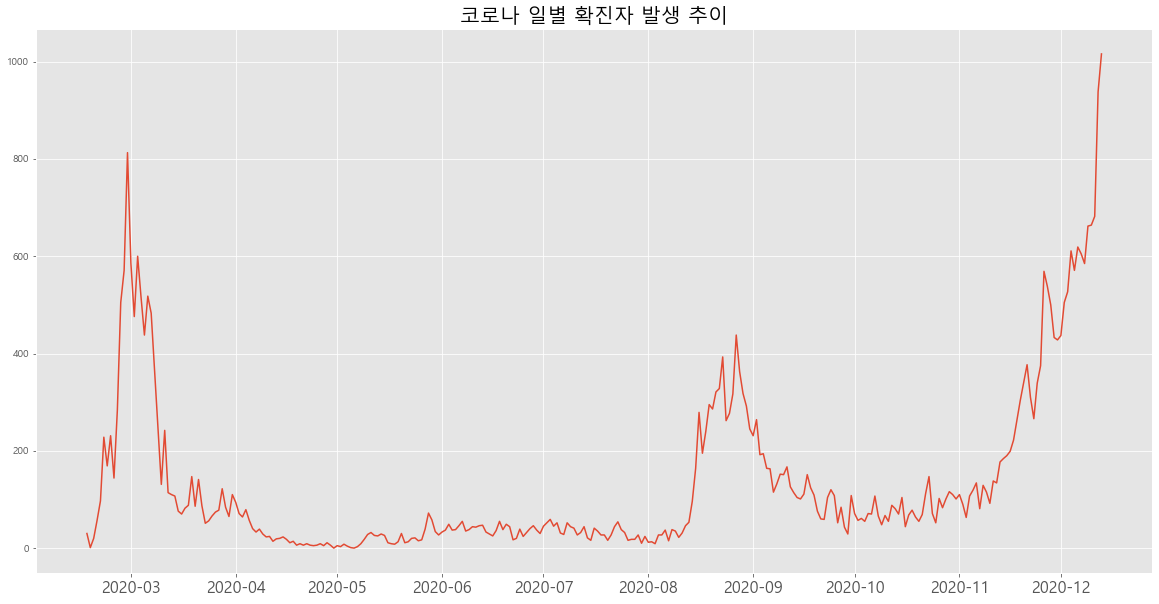

In [46]:
import matplotlib.pyplot as plt

plt.rc('font', family = 'Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.style.use("ggplot")

plt.figure(figsize=(20,10))
plt.plot(date_total_df)
plt.title('코로나 일별 확진자 발생 추이', fontsize=20)
plt.xticks(fontsize=16)

fig = plt.gcf()
fig.savefig('corona_date.png', dpi=fig.dpi)